In [21]:
%load_ext autoreload
%autoreload 2

import torch
torch.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.6.0'

In [22]:
import numpy as np
import torch
import random
import pickle
import sys
import os
import glob
import pdb
sys.path.insert(0, '/home/jupyter/VLP/pythia')
sys.path.insert(0, '/home/jupyter/VLP/')

from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertForPreTrainingLossMask
from pytorch_pretrained_bert.optimization import BertAdam
from pathlib import Path
import pandas as pd
from vlp.loader_utils import batch_list_to_batch_tensors
import vlp.seq2seq_loader as seq2seq_loader
import PIL
from vlp.lang_utils import language_eval

from fastai.vision.all import *

from vlp_processor import PreprocessVLP
import pythia.tasks.processors as pythia_proc

from util import *

In [23]:
class ArgDummy(dict):
    def __getattr__(self, attr):
        return self[attr]
args = ArgDummy()
DATA_ROOT = '/mnt/ssd/data'
HATE_FEAT_PATH = Path('/home/jupyter/hateful_features/region_feat_gvd_wo_bgd')

args['bert_model'] = 'bert-base-cased' #Bert pre-trained model selected
args['seed'] = 123 #random seed for initialization
args['len_vis_input'] = 100
args['max_tgt_length'] = 100#20 #maximum length of target sequence
args['region_det_file_prefix'] = 'feat_cls_1000/coco_detection_vg_100dets_gvd_checkpoint_trainval'
args['output_dir'] ='tmp'
args['drop_prob'] = 0.1
args['model_recover_path'] = './checkpoints/vqa2_g2_lr2e-5_batch512_ft_from_s0.75_b0.25/model.19.bin'
args['image_root'] = f'{DATA_ROOT}/flickr30k/region_feat_gvd_wo_bgd/'
args['region_bbox_file'] =f'{DATA_ROOT}/flickr30k/region_feat_gvd_wo_bgd/flickr30k_detection_vg_thresh0.2_feat_gvd_checkpoint_trainvaltest.h5'
args['do_lower_case'] = True
args.region_bbox_file = os.path.join(args.image_root, args.region_bbox_file)
args.region_det_file_prefix = os.path.join(args.image_root, args.region_det_file_prefix)
args.max_seq_length = args.max_tgt_length + args.len_vis_input + 3 # +3 for 2x[SEP] and [CLS]

In [24]:
device = torch.device('cuda')
# fix random seed
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=args.do_lower_case)
tokenizer.max_len = args.max_seq_length

In [25]:
class HateStem(torch.nn.Module):
    
    def __init__(self, vlp):
        super(HateStem, self).__init__()
        self.vis_embed = vlp.vis_embed #Linear->ReLU->Linear->ReLU->dropout
        self.vis_pe_embed = vlp.vis_pe_embed #Linear->ReLU->dropout
        self.bert = vlp.bert # pytorch_pretrained_bert.modeling.BertModel
        self.len_vis_input = vlp.len_vis_input
        
    
    def forward(self, vis_feats, vis_pe, input_ids, token_type_ids=None, attention_mask=None):
        vis_feats = self.vis_embed(vis_feats) # image region features
        vis_pe = self.vis_pe_embed(vis_pe) # image region positional encodings

        sequence_output, pooled_output = self.bert(vis_feats, vis_pe, input_ids, token_type_ids,
            attention_mask, output_all_encoded_layers=False, len_vis_input=self.len_vis_input)
        #print(sequence_output.shape, pooled_output.shape)
        vqa2_embed = sequence_output[:, 0]*sequence_output[:, self.len_vis_input+1]
        return vqa2_embed
        #return sequence_output


In [26]:
def create_head(nf, n_out, lin_ftrs=None, ps=0.5, bn_final=False, lin_first=False, ):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and out `n_out` classes."
    lin_ftrs = [nf, 512, n_out] if lin_ftrs is None else [nf] + lin_ftrs + [n_out]
    ps = L(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = []
    layers = [Flatten()]
    if lin_first: layers.append(nn.Dropout(ps.pop(0)))
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += LinBnDrop(ni, no, bn=True, p=p, act=actn, lin_first=lin_first)
    if lin_first: layers.append(nn.Linear(lin_ftrs[-2], n_out))
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)

In [27]:
class HateClassifier(torch.nn.Module):
     def __init__(self, stem):
        super(HateClassifier, self).__init__()
        self.stem = stem
        self.classifier = create_head(768,2, ps=.5)
     #def forward(self, id, vis_feats, vis_pe, input_ids, token_type_ids, attention_mask):  
     def forward(self, params):  
        id, vis_feats, vis_pe, input_ids, token_type_ids, attention_mask = params
        embs = self.stem(vis_feats, vis_pe, input_ids, token_type_ids, attention_mask)
        return self.classifier(embs)

In [28]:
def new_model():
    hate_stem = torch.load('checkpoints/lm_stem20drop.pth')
    
    return  HateClassifier(hate_stem).cuda()


In [29]:
path =  Path('/home/jupyter/VLP')
data =pd.read_csv(path/'captioned.csv')
data[:3]

,id,img,label,text,caption,is_valid,tex_cap
0,42953,img/42953.png,0.0,its their character not their color that matters,A man in a black shirt is looking at the camera .,False,A man in a black shirt is looking at the camera . <meme> its their character not their color that matters
1,23058,img/23058.png,0.0,don't be afraid to love again everyone is not like your ex,A man in a suit is talking to a woman in a white shirt .,False,A man in a suit is talking to a woman in a white shirt . <meme> don't be afraid to love again everyone is not like your ex
2,13894,img/13894.png,0.0,putting bows on your pet,A cat with a red bow tied around its neck sits next to a pillow .,False,A cat with a red bow tied around its neck sits next to a pillow . <meme> putting bows on your pet


In [30]:
def load(idx, proc, q=None):
    return load_from_row(data.iloc[idx],proc, tokenizer, q)

In [40]:
region_pref = HATE_FEAT_PATH / 'feat_cls_1000/hateful_vlp_checkpoint_trainval'
bbox_pref = HATE_FEAT_PATH / 'raw_bbox/hateful_vlp_checkpoint_trainval'
id_digits=2

truncate_config={
    'max_len_b': args.max_tgt_length, 'trunc_seg': 'b', 'always_truncate_tail': True}

max_masked = 10
mask_prob = .20
mask_img=True
vis_mask_prob = .20
train_proc = PreprocessVLP(max_masked, mask_prob,
    list(tokenizer.vocab.keys()), tokenizer.convert_tokens_to_ids, args.max_seq_length,
    truncate_config=truncate_config,mask_image_regions=mask_img, vis_mask_prob=vis_mask_prob,
    mode="bi", len_vis_input=args.len_vis_input, 
    region_bbox_prefix=str(bbox_pref), region_det_file_prefix=str(region_pref), id_digits=id_digits,
    load_vqa_ann=True)

val_proc = PreprocessVLP(0, 0,
    list(tokenizer.vocab.keys()), tokenizer.convert_tokens_to_ids, args.max_seq_length,
    truncate_config=truncate_config,mask_image_regions=False, vis_mask_prob=0,
    mode="bi", len_vis_input=args.len_vis_input, 
    region_bbox_prefix=str(bbox_pref), region_det_file_prefix=str(region_pref), id_digits=id_digits,
    load_vqa_ann=True)

In [41]:


def get_y(row):
    return int(row['label'])

class LoadRow(Transform):
   
    def __init__(self, split_idx, processor, tokenizer):
        self.split_idx = split_idx
        self.proc = processor
        self.tokenizer = tokenizer
    
    def encodes(self, x, **kwargs):
        return load_from_row(x, self.proc, self.tokenizer)

In [33]:
@typedispatch
def show_batch(x:VLPInput, y, samples, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

@typedispatch
def show_results(x:VLPInput, y:TensorCategory, samples, outs, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, add_vert=1, figsize=figsize)
    for i in range(2):
        ctxs = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i),ctxs,range(max_n))]
    ctxs = [r.show(ctx=c, color='green' if b==r else 'red', **kwargs)
            for b,r,c,_ in zip(samples.itemgot(1),outs.itemgot(0),ctxs,range(max_n))]
    return ctxs


@typedispatch
def plot_top_losses(x: VLPInput, y:TensorCategory, samples, outs, raws, losses, nrows=None, ncols=None, figsize=None, **kwargs):
    axs = get_grid(len(samples), nrows=nrows, ncols=ncols, add_vert=1, figsize=figsize, title='Prediction/Actual/Loss/Probability')
    for ax,s,o,r,l in zip(axs, samples, outs, raws, losses):
        s[0].show(ctx=ax, **kwargs)
        ax.set_title(f'{o}/{s[1]} / {l.item():.2f} / {r.max().item():.2f}')

In [42]:
db = DataBlock(blocks = (TransformBlock, CategoryBlock), 
               get_x = Pipeline([LoadRow(0, train_proc, tokenizer),LoadRow(1, val_proc, tokenizer)]), 
               get_y=get_y,  splitter=ColSplitter('is_valid'))
dls = db.dataloaders(data[:9000],bs=32, device=device)

len(dls.train_ds), len(dls.valid_ds)

(8500, 500)

In [43]:


@patch_to(VLPInput)
def show(self, ctx, **kwargs):
    id = self[0].item()
    tit = id_to_text(id, data)
    ctx.text(0,0,tit,ha='left', wrap=True)
    ctx = show_image(PILImage.create(id_to_img_path(id)), ctx=ctx)
    return ctx


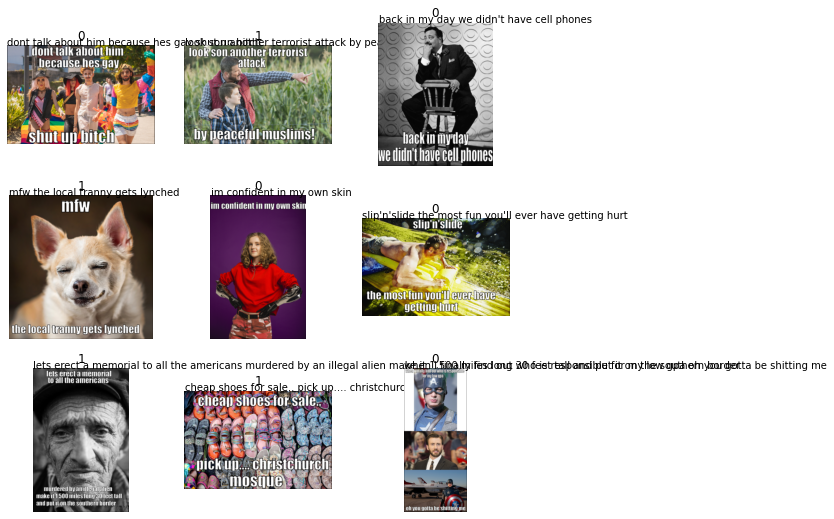

In [44]:
dls.show_batch(dls.one_batch(), 9)

In [45]:
def vlp_splitter(model):
    return L(params(model.stem.vis_embed) + params(model.stem.vis_pe_embed), 
            params(model.stem.bert),
            params(model.classifier))

In [46]:
model = new_model()
learn = Learner(dls, model,metrics=[accuracy, RocAucBinary()], splitter=vlp_splitter)

In [47]:
learn.fit_one_cycle(8, lr_max=5e-5)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.761020,0.703793,0.574000,0.603712,03:11
1,0.682958,0.690652,0.598000,0.647728,03:10
2,0.594833,0.763357,0.624000,0.689264,03:11
3,0.524039,0.665563,0.632000,0.733264,03:11
4,0.445633,0.810233,0.628000,0.718368,03:11
5,0.406882,0.811852,0.660000,0.744016,03:10
6,0.349289,0.834763,0.656000,0.756400,03:11
7,0.297175,0.871478,0.668000,0.754272,03:11


In [2]:
#learn.recorder.plot_loss()

In [48]:
learn.save('attempt22')

Path('models/attempt22.pth')

In [49]:
gen_submit(learn, 'attempts/attempt22.csv', True)

/home/jupyter/dl_experiments/Hateful/util.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = F.softmax(preds)


In [50]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()

              precision    recall  f1-score   support

           0       0.62      0.87      0.72       250
           1       0.78      0.47      0.59       250

    accuracy                           0.67       500
   macro avg       0.70      0.67      0.65       500
weighted avg       0.70      0.67      0.65       500



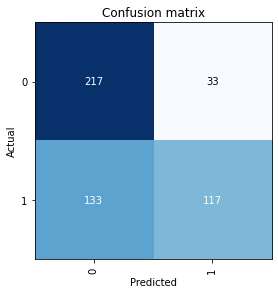

In [51]:
interp.plot_confusion_matrix()

In [52]:
def plot_top_lossesss(self, k, largest=True, **kwargs):
        losses,idx = self.top_losses(k, largest)
        if not isinstance(self.inputs, tuple): self.inputs = (self.inputs,)
        if isinstance(self.inputs[0], Tensor): inps = tuple(o[idx] for o in self.inputs)
        else: inps = self.dl.create_batch(self.dl.before_batch([tuple(o[i] for o in self.inputs) for i in idx]))
        by = self.targs[idx]
        b = inps, by 
        
        x,y,its = self.dl._pre_show_batch(b, max_n=k)
        b_out = inps, self.decoded[idx]
        x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
        plot_top_losses(x, y, its, self.decoded[idx], self.preds[idx], losses,  **kwargs)


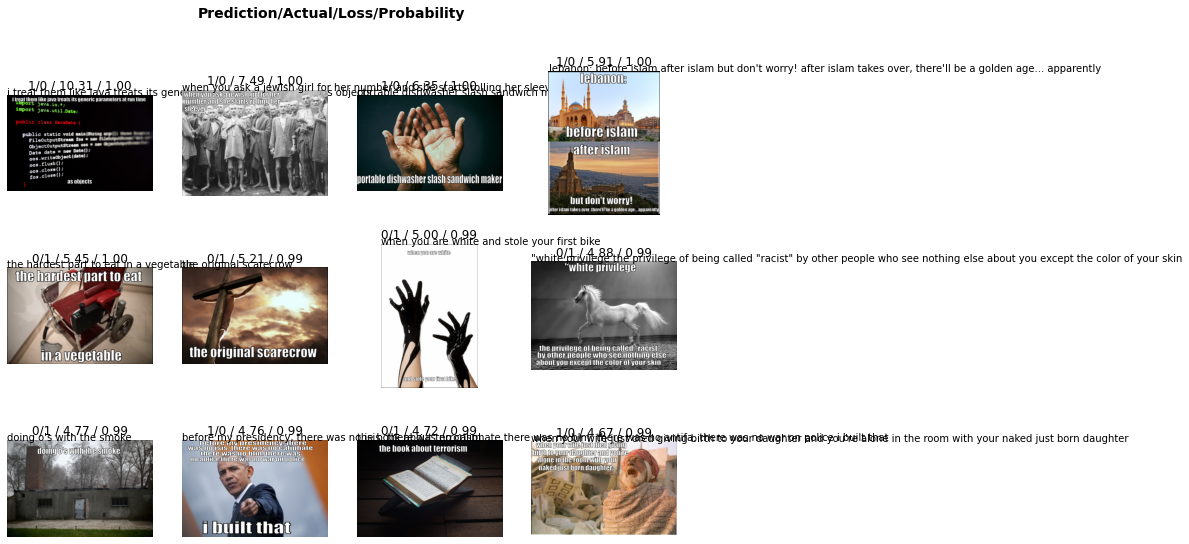

In [55]:
plot_top_lossesss(interp, 12)

In [56]:
preds_v = learn.get_preds(dl = dls.valid)

In [57]:
preds_t = learn.get_preds(ds_idx=0)

In [58]:
import sklearn
def get_roc(preds):
    preds, y = preds
    probs = F.softmax(preds, dim=1)[:,1]
    
    return sklearn.metrics.roc_auc_score(y, probs)

def get_wilxon(preds):
    preds, y = preds
    probs = F.softmax(preds, dim=1)[:,1]
    sx = probs[y==1]
    sy = probs[y==0]
    #print(sx.mean(), sy.mean())
    M =sx.unsqueeze(0) > sy.unsqueeze(1)
    return M.sum().float() /tensor(M.numel())
def sg(x):
    return 1 / (1 + torch.exp(-1*x))
def get_loss(preds):
    preds, y = preds
    probs = preds[:,1]
    sx = probs[y==1]
    sy = probs[y==0]
    M = sx.unsqueeze(0) - sy.unsqueeze(1)
    M = sg(M)
    return M.sum() /tensor(M.numel())

In [59]:
get_roc(preds_t), get_roc(preds_v)

(0.9669278387727478, 0.7542719999999998)

In [60]:
get_loss(preds_t), get_loss(preds_v)

(tensor(0.6714), tensor(0.5695))

In [61]:
get_wilxon(preds_t), get_wilxon(preds_v)

(tensor(0.9669), tensor(0.7543))

In [62]:
def get_all_embs(model, dl):
    E=[]
    Y =[]
    model.eval()
    with torch.no_grad():
        for bx, by in dl:
            _, vis_feats, vis_pe, input_ids, token_type_ids, attention_mask = bx
            embs = model.stem(vis_feats, vis_pe, input_ids, token_type_ids, attention_mask)
            E.append(embs)
            Y.append(by)
        allE = torch.cat(E)
        allY = torch.cat(Y)
    return allE, allY

In [63]:
trainE, trainY = get_all_embs(model, dls.train)
trainE.shape, trainY.shape

(torch.Size([8480, 768]), torch.Size([8480]))

In [64]:
validE, validY = get_all_embs(model, dls.valid)
validE.shape, validY.shape

(torch.Size([500, 768]), torch.Size([500]))

In [65]:
learn.load('attempt22')
md_cls = learn.model.classifier

In [66]:
opt = torch.optim.SGD(md_cls.parameters(), lr=1e-1)

In [67]:
def count_roc(md, x,y):
    md = md.eval()
    pred = md(x)
    return get_wilxon((pred,y))

In [68]:
md_cls = md_cls.train()
for i in range(500):
    opt.zero_grad()
    trainPred = md_cls(trainE)
    lss = 1*(1-get_loss((trainPred, trainY)))
    lss.backward()
    opt.step()
    if i%50 == 0:
        roc_train = count_roc(md_cls, trainE, trainY)
        roc_valid = count_roc(md_cls, validE, validY)
        md_cls = md_cls.train()
        print([x.item() for x in (lss, roc_train, roc_valid)])

[0.10421085357666016, 0.9682607650756836, 0.7523840069770813]
[0.03827095031738281, 0.9685908555984497, 0.7504799962043762]
[0.03578460216522217, 0.9689033031463623, 0.7499520182609558]
[0.03485286235809326, 0.9692023396492004, 0.750111997127533]
[0.03458595275878906, 0.9694488048553467, 0.7501919865608215]
[0.03411877155303955, 0.9696162343025208, 0.7503679990768433]
[0.033224284648895264, 0.9698545932769775, 0.7503039836883545]
[0.03269082307815552, 0.9701024293899536, 0.7507359981536865]
[0.03259146213531494, 0.9703230857849121, 0.7509920001029968]
[0.03220343589782715, 0.9705718755722046, 0.750976026058197]
